## Kidney Stone Classification using CT_Images

## Importing Libraries

In [1]:
!pip install gradio


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
import random
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import cv2 
from skimage.feature import hog 
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix
import gradio as gr

C:\Users\Admin\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


## Preparing Traning Data

In [3]:
folder_path = "C:\\Users\\Admin\\Downloads\\Kidney_Stone_Detection-main\\Kidney_Stone_Detection-main\\Kidney-Stone-Detection-main\\CT_images\\Train"
filenames = []
categories = []

for category in os.listdir(folder_path):
    category_path = os.path.join(folder_path, category)
    
    if os.path.isdir(category_path):
        for filename in os.listdir(category_path):
            filenames.append(os.path.join(category, filename))
            categories.append(category)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [4]:
df.head()

,filename,category
0,Normal\Normal- (1).jpg,Normal
1,Normal\Normal- (10).jpg,Normal
2,Normal\Normal- (100).jpg,Normal
3,Normal\Normal- (1000).jpg,Normal
4,Normal\Normal- (101).jpg,Normal


In [5]:
df.tail()

,filename,category
2995,Stone\Stone- (995).jpg,Stone
2996,Stone\Stone- (996).jpg,Stone
2997,Stone\Stone- (997).jpg,Stone
2998,Stone\Stone- (998).jpg,Stone
2999,Stone\Stone- (999).jpg,Stone


<Axes: >

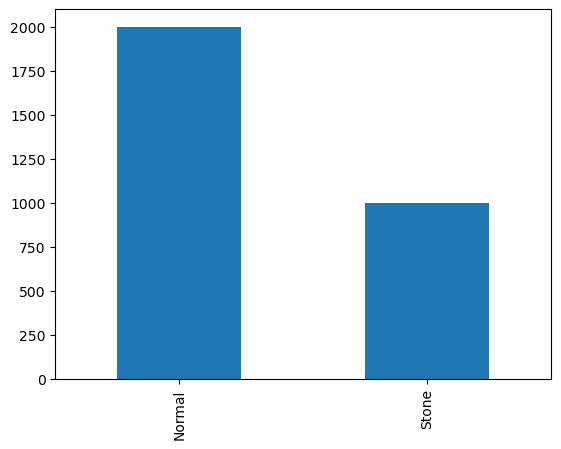

In [6]:
df['category'].value_counts().plot.bar()

We have 3000 total images (2000 Normal, 1000 Stone)

## Visualizing Data

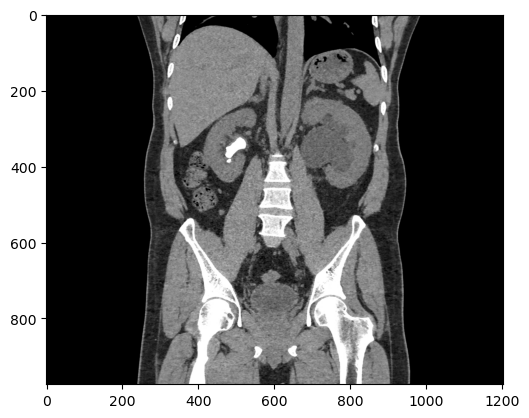

In [7]:
sample = random.choice(filenames)
image = load_img("./CT_Images/Train/"+sample)
plt.imshow(image)

# CNN(Convolutional Neural Network)

## Building CNN Model

In [8]:
model = Sequential()

#Adding convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

#Adding a second convolutional layer
model.add(Conv2D(64, (3, 3) , activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())  # this converts our feature maps to 1D feature vectors
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2)) # as we have binary class i.e stone and normal so value is 2
model.add(Activation('sigmoid')) #sigmoid for binary class classification

C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 148, 148, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 72, 72, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 82944)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      10,616,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 2)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,637,506 (40.58 MB)

 Trainable params: 10,637,058 (40.58 MB)

 Non-trainable params: 448 (1.75 KB)

### Call Backs

#### Early Stop
To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased

In [10]:
earlystop = EarlyStopping(patience=10)

#### Learning Rate Reduction
We will reduce the learning rate when then accuracy not increase for 2 steps

In [11]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [12]:
callbacks = [earlystop, learning_rate_reduction]

### Preparing Data

In [13]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<Axes: >

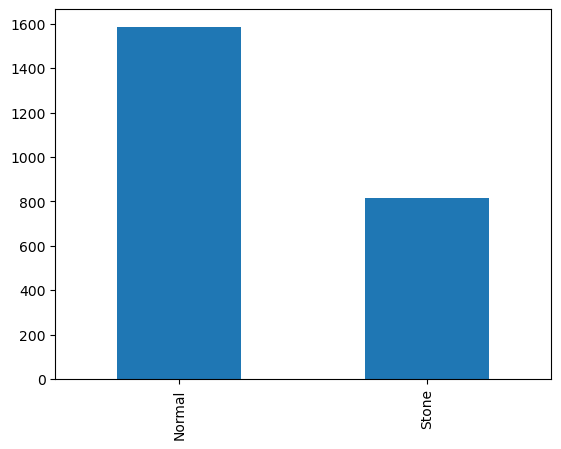

In [14]:
train_df['category'].value_counts().plot.bar()

<Axes: >

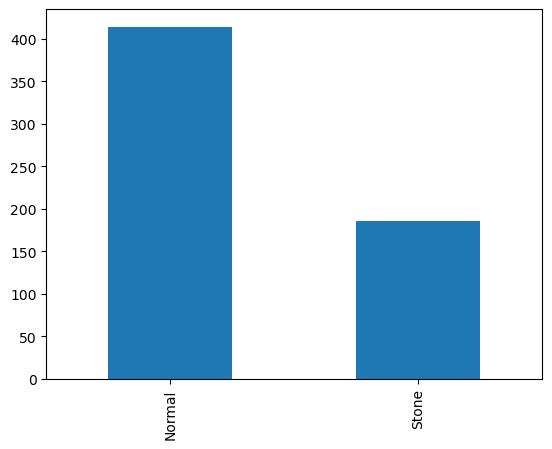

In [15]:
validate_df['category'].value_counts().plot.bar()

### Train and Validation generator

In [16]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

validation_datagen = ImageDataGenerator(rescale=1./255)

In [17]:
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "C:\\Users\\Admin\\Downloads\\Kidney_Stone_Detection-main\\Kidney_Stone_Detection-main\\Kidney-Stone-Detection-main\\CT_images\\Train", 
    x_col='filename',
    y_col='category',
    target_size=(150,150),
    class_mode='categorical',
    batch_size=15
)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "C:\\Users\\Admin\\Downloads\\Kidney_Stone_Detection-main\\Kidney_Stone_Detection-main\\Kidney-Stone-Detection-main\\CT_images\\Train", 
    x_col='filename',
    y_col='category',
    target_size=(150,150),
    class_mode='categorical',
    batch_size=15
)

Found 2400 validated image filenames belonging to 2 classes.
Found 600 validated image filenames belonging to 2 classes.


### Visulaizing the output of data gen

In [18]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "C:\\Users\\Admin\\Downloads\\Kidney_Stone_Detection-main\\Kidney_Stone_Detection-main\\Kidney-Stone-Detection-main\\CT_images\\Train", 
    x_col='filename',
    y_col='category',
    target_size=(150,150),
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


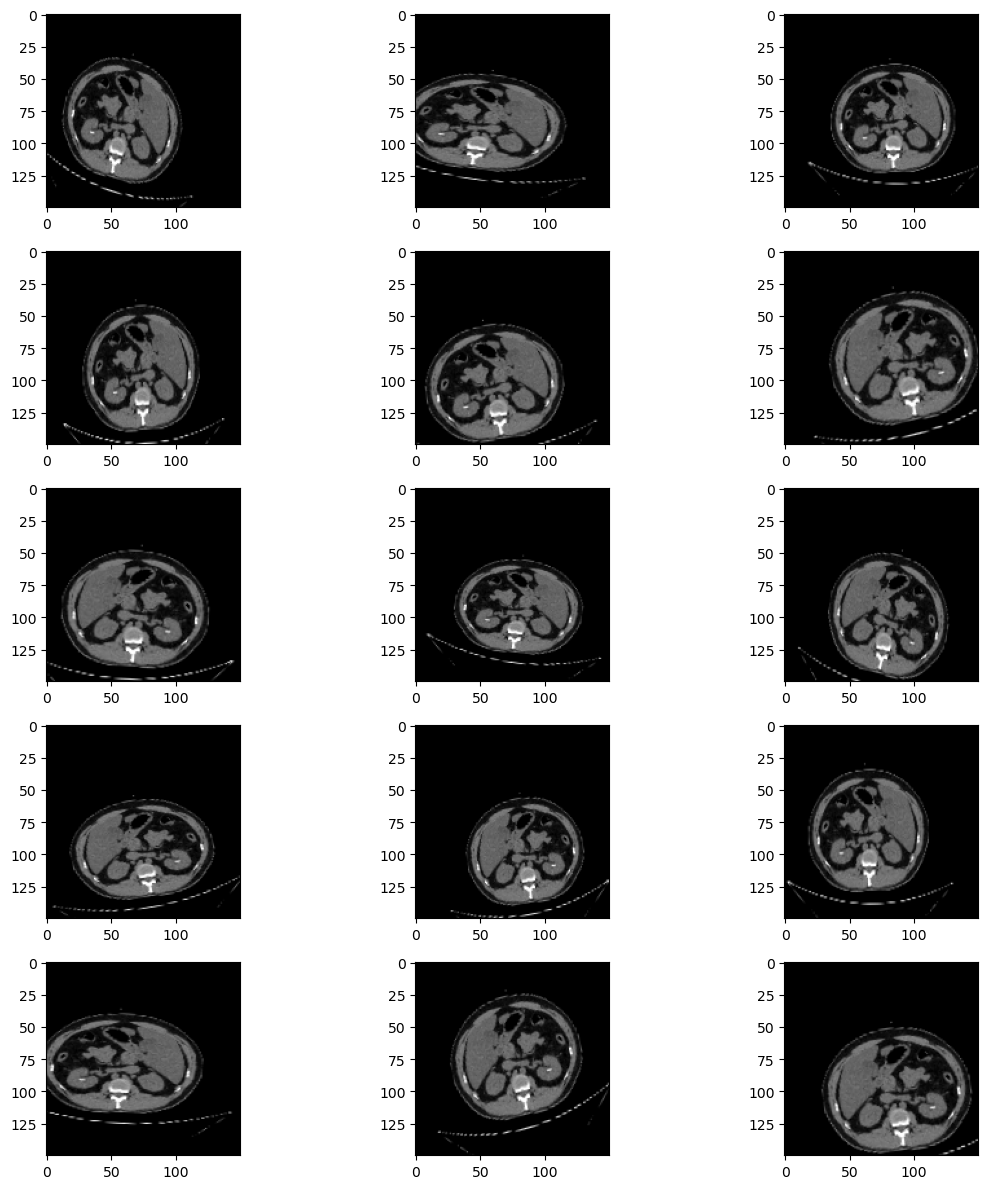

In [19]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

### Fitting the Model

In [20]:
# Compiling the model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [21]:
history = model.fit(
    train_generator, 
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validate_df.shape[0]//15,
    steps_per_epoch=train_df.shape[0]//15,
    callbacks=callbacks
)

Epoch 1/50


C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


160/160 ━━━━━━━━━━━━━━━━━━━━ 140s 817ms/step - accuracy: 0.6990 - loss: 0.7089 - val_accuracy: 0.8417 - val_loss: 0.6390 - learning_rate: 0.0010
Epoch 2/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/50


C:\Users\Admin\anaconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\callbacks\callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_accuracy` which is not available. Available metrics are: accuracy,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


160/160 ━━━━━━━━━━━━━━━━━━━━ 129s 792ms/step - accuracy: 0.8538 - loss: 0.3523 - val_accuracy: 0.7583 - val_loss: 0.6372 - learning_rate: 0.0010
Epoch 4/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 659ms/step - accuracy: 0.8757 - loss: 0.3203
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
160/160 ━━━━━━━━━━━━━━━━━━━━ 118s 718ms/step - accuracy: 0.8757 - loss: 0.3202 - val_accuracy: 0.7567 - val_loss: 0.4978 - learning_rate: 0.0010
Epoch 6/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 7/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 125s 767ms/step - accuracy: 0.8942 - loss: 0.2648 - val_accuracy: 0.8917 - val_loss: 0.2371 - learning_rate: 5.0000e-04
Epoch 8/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 9/50
160/160 ━

### Visualizing the Training history

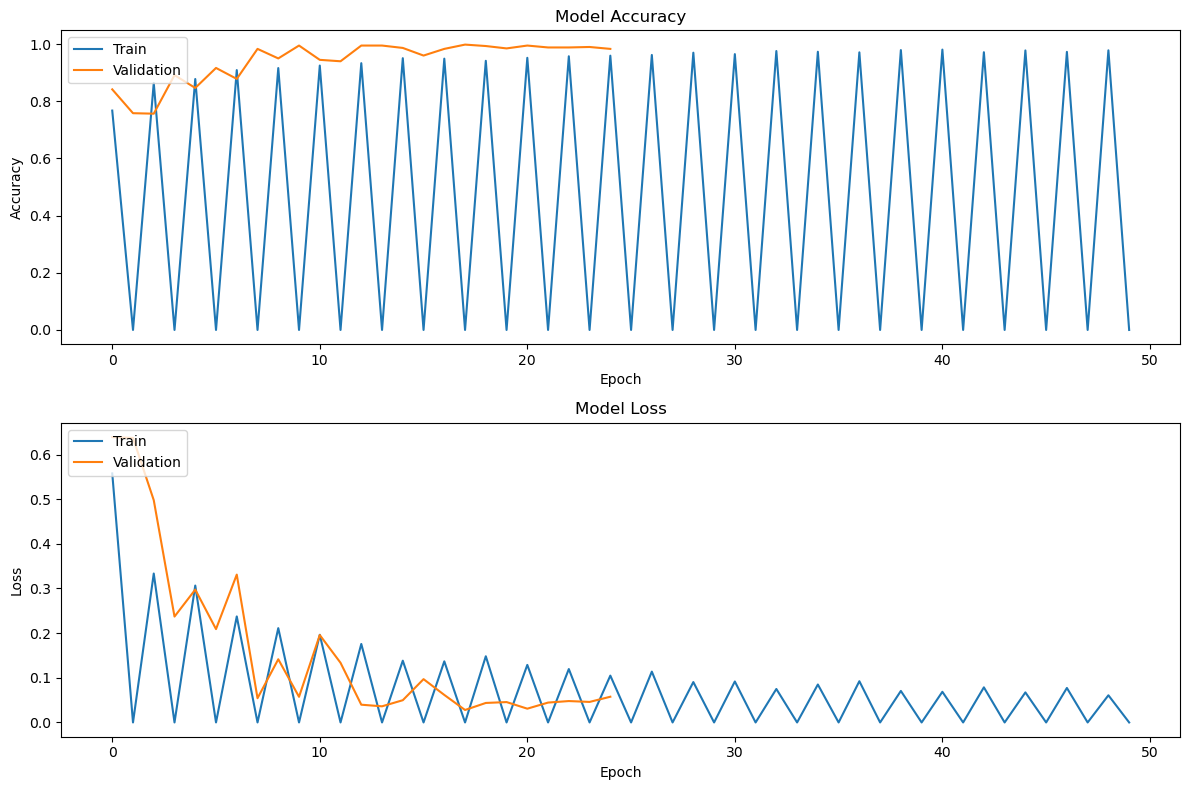

In [22]:
# Plotting the training history
plt.figure(figsize=(12, 8)) 

# Plot training & validation accuracy values
plt.subplot(2, 1, 1)  # 2 rows, 1 column, first subplot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(2, 1, 2)  # 2 rows, 1 column, second subplot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

### Saving the CNN Model

In [23]:
# Saving the Model
model.save('kidney_stone_detection_model.h5')

### Testing Data

In [24]:
test_folder_path = "C:\\Users\\Admin\\Downloads\\Kidney_Stone_Detection-main\\Kidney_Stone_Detection-main\\Kidney-Stone-Detection-main\\CT_images\\Test"
test_filenames = []
test_categories = []

for category in os.listdir(test_folder_path):
    test_category_path = os.path.join(test_folder_path, category)
    
    if os.path.isdir(test_category_path):
        for filename in os.listdir(test_category_path):
            test_filenames.append(os.path.join(category, filename))
            test_categories.append(category)

test_df = pd.DataFrame({
    'filename': test_filenames,
    'category': test_categories
})

In [25]:
test_gen = ImageDataGenerator(rescale=1./255)

test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "C:\\Users\\Admin\\Downloads\\Kidney_Stone_Detection-main\\Kidney_Stone_Detection-main\\Kidney-Stone-Detection-main\\CT_images\\Test", 
    x_col='filename',
    y_col='category',
    target_size=(150,150),
    class_mode='categorical',
    batch_size=15,
    shuffle=False
)

Found 900 validated image filenames belonging to 2 classes.


### Predictions

In [26]:
steps = int(np.ceil(test_df.shape[0] / 15))

predict = model.predict(test_generator, steps=steps)

C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


60/60 ━━━━━━━━━━━━━━━━━━━━ 15s 235ms/step


In [27]:
test_df['predicted category'] = np.argmax(predict, axis=-1)

In [28]:
test_df['predicted category'] = test_df['predicted category'].replace({ 1: 'Stone', 0: 'Normal' })

In [29]:
test_df.head()

,filename,category,predicted category
0,Normal\Normal- (1001).jpg,Normal,Normal
1,Normal\Normal- (1002).jpg,Normal,Normal
2,Normal\Normal- (1003).jpg,Normal,Normal
3,Normal\Normal- (1004).jpg,Normal,Normal
4,Normal\Normal- (1005).jpg,Normal,Normal


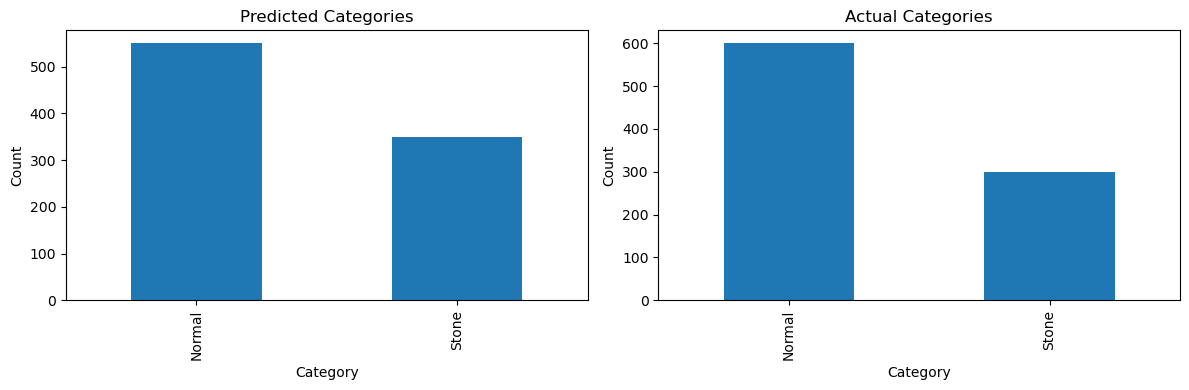

In [30]:
plt.figure(figsize=(12, 4))

# Plot the first bar plot (predicted category)
plt.subplot(1, 2, 1)
test_df['predicted category'].value_counts().plot.bar()
plt.title('Predicted Categories')
plt.xlabel('Category')
plt.ylabel('Count')

# Plot the second bar plot (actual category)
plt.subplot(1, 2, 2)
test_df['category'].value_counts().plot.bar()
plt.title('Actual Categories')
plt.xlabel('Category')
plt.ylabel('Count')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

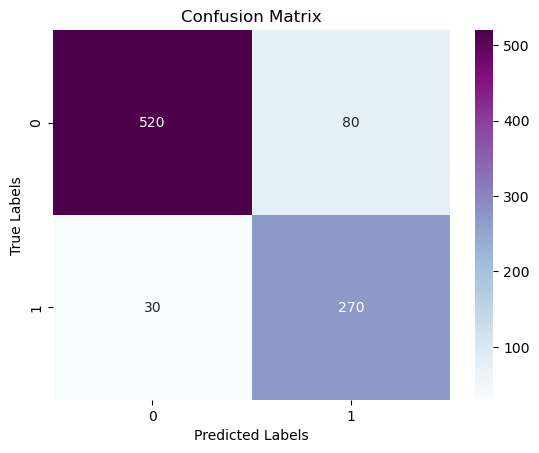

In [31]:
cm = confusion_matrix(test_df['category'], test_df['predicted category'])

sns.heatmap(cm, annot=True, fmt='d', cmap='BuPu')

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

plt.show()

The results is baised toward normal as we have more Normal Images 

In [32]:
model.evaluate(test_generator)

60/60 ━━━━━━━━━━━━━━━━━━━━ 13s 216ms/step - accuracy: 0.9138 - loss: 0.4510


[0.5832619667053223, 0.8777777552604675]

# SVM

In [33]:
#Defining a function to read images from the train and test folders
def read_images(path):
    images_list = []
    for filename in os.listdir(path):
        img = cv2.imread(os.path.join(path,filename))
        if img is not None:
            images_list.append(img)
    return images_list

In [34]:
#Reading train images from the normal and stone folders
train_normal = read_images(r'C:\\Users\\Admin\\Downloads\\Kidney_Stone_Detection-main\\Kidney_Stone_Detection-main\\Kidney-Stone-Detection-main\\CT_images\\Train\Normal')
train_stone = read_images(r'C:\\Users\\Admin\Downloads\\Kidney_Stone_Detection-main\\Kidney_Stone_Detection-main\\Kidney-Stone-Detection-main\\CT_images\\Train\\Stone')

In [35]:
#Creating a list of labels for training 
labels = ['Normal' for item in train_normal] + ['Stone' for item in train_stone]

In [36]:
#Defining a function for HOG feature extraction
def extract_features(images):
    feature_list = []
    for img in images:
        fd, hog_image = hog(img, orientations=8, pixels_per_cell=(16, 16), 
                            cells_per_block=(1, 1), visualize=True, channel_axis=2)
        # Resize the HOG features to a fixed size
        fd = np.resize(fd, (2400, 1))
        # Flatten the array to 2 dimensions
        fd = fd.flatten()
        feature_list.append(fd)
    return feature_list

In [37]:
#Extracting the HOG features from both normal and stone images
feature_list_normal = extract_features(train_normal)
feature_list_stone = extract_features(train_stone)

In [38]:
print(len(feature_list_normal))
print(len(feature_list_stone))

2000
1000


In [39]:
# Combining the features for both classes
features = feature_list_normal + feature_list_stone

In [40]:
#Reading test images from the normal and stone folders
test_normal = read_image('C:\\Users\\Admin\\Downloads\\Kidney_Stone_Detection-main\\Kidney_Stone_Detection-main\\Kidney-Stone-Detection-main\\CT_images\\Test\Normal')
test_stone = read_images('C:\\Users\\Admin\\Downloads\\Kidney_Stone_Detection-main\\Kidney_Stone_Detection-main\\Kidney-Stone-Detection-main\\CT_images\\Test\\Stone')

In [41]:
#Creating a list of labels for testing 
test_labels = ['Normal' for item in test_normal] + ['Stone' for item in test_stone]

In [42]:
#Creating a Feature Vector for Test Set
test_feature_list_normal = extract_features(test_normal)
test_feature_list_stone = extract_features(test_stone)

In [43]:
print(len(test_feature_list_normal))
print(len(test_feature_list_stone))

600
300


In [44]:
#Combining the features for both classes
test_features = test_feature_list_normal + test_feature_list_stone

In [45]:
#Splitting the data into train and valid sets
X_train, X_valid, y_train, y_valid = train_test_split(features, labels, test_size=0.2, random_state=0)

In [46]:
# Print the shape of the first element in the X_train array
print(X_train[0].shape)

# Print the shape of the second element in the X_train array
print(X_train[1].shape)

# Print the shape of the last element in the X_train array
print(X_train[-1].shape)

(2400,)
(2400,)
(2400,)


In [47]:
# Training a SVM Model
svc = SVC(kernel='rbf', C=1, gamma='auto')
svc.fit(X_train, y_train)

SVC(C=1, gamma='auto')

In [48]:
# Predicting the Test Set
y_pred = svc.predict(X_valid)

In [49]:
#Calculating the accuracy
accuracy = accuracy_score(y_valid, y_pred)
print("Accuracy : ", accuracy)

Accuracy :  0.7966666666666666


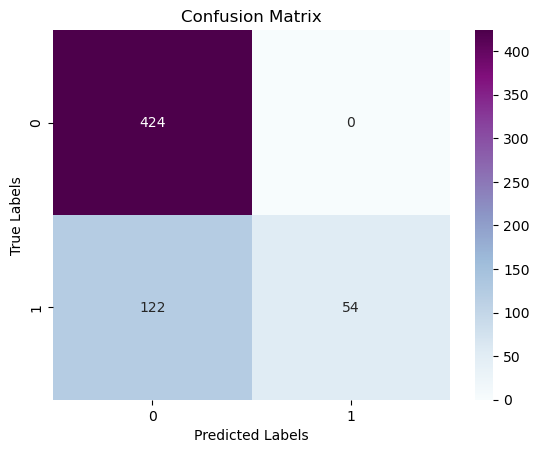

In [50]:
svm_cm = confusion_matrix(y_valid, y_pred)

sns.heatmap(svm_cm, annot=True, fmt='d', cmap='BuPu')

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

plt.show()

Same case is with the SVM it is also baised towrads the Normal 

In [51]:
import sklearn.externals
import joblib

# Save the model to a file
joblib.dump(svc, 'svc.pkl')

['svc.pkl']

# # Model Performance

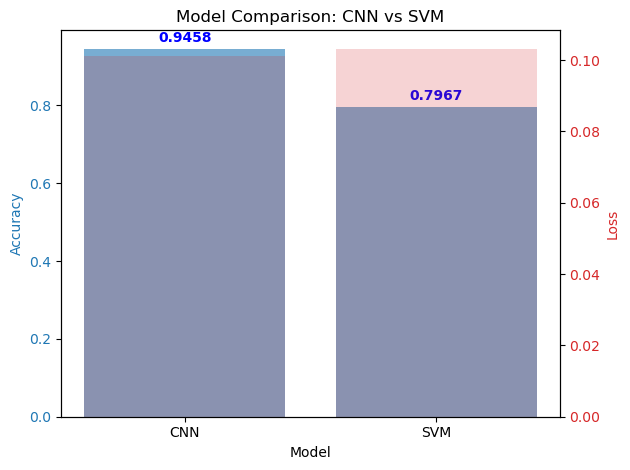

In [1]:
import matplotlib.pyplot as plt

# Data for the comparison
models = ['CNN', 'SVM']
accuracy = [0.9458, 0.7967]  # CNN accuracy, SVM accuracy
loss = [0.1011, 0.1032]      # CNN loss, SVM loss (for comparison)

# Create figure and axes
fig, ax1 = plt.subplots()

# Plot accuracy as a bar plot
bars = ax1.bar(models, accuracy, color='tab:blue', alpha=0.6, label='Accuracy')

# Display accuracy values on top of bars
for i, bar in enumerate(bars):
    ax1.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,  # Positioning the text
             f'{accuracy[i]:.4f}', ha='center', va='bottom', color='blue', fontweight='bold')

# Create a second y-axis for loss 
ax2 = ax1.twinx()
ax2.set_ylabel('Loss', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

ax2.bar(models, loss, color='tab:red', alpha=0.2)  # Loss shown in light red 

# Add labels
ax1.set_xlabel('Model')
ax1.set_ylabel('Accuracy', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Add a title and show the plot
plt.title('Model Comparison: CNN vs SVM')
fig.tight_layout()
plt.show()


In [52]:
from keras.models import load_model
model = load_model('kidney_stone_detection_model.h5')
import sklearn.externals
import joblib
svc = joblib.load("svc.pkl")

In [53]:
# Function to Select Image
def browse_btn():
    global image_name
    
    label_cnn.configure(text="")
    label.configure(text="")
    
    image_name = askopenfilename(title='Select Image')
    img = Image.open(image_name)
    img = img.resize((200, 200), Image.ANTIALIAS)
    img = ImageTk.PhotoImage(img)
    panel = tk.Label(root, image=img)
    panel.image = img
    panel.grid(row=0,column=1,sticky='nw',padx=20,pady=28)

In [54]:
# Function to Predict CNN
def predict_btn_cnn():
    global label_prediction
    global image_name
    test_img = image.load_img(image_name, target_size=(150, 150))
    test_img = image.img_to_array(test_img)
    test_img = np.expand_dims(test_img, axis=0)
    result = model.predict(test_img)
    if result[0][0] == 1:
        label_cnn.configure(text="Kidney Stone Detected")
    elif result[0][0] == 0:
        label_cnn.configure(text="No Kidney Stone Detected")

In [55]:
#Function for Predict SVM        
def predict_btn_svm():
    global label_prediction
    global image_name
    test_img = cv2.imread(image_name)
    #test_img = image.load_img(image_name, target_size=(150, 150))
    #test_img = image.img_to_array(test_img)
    feature_list_of_img = extract_features([test_img])
    result = svc.predict(feature_list_of_img)    
    #Displaying the output
    if result[0] == 'Stone':
        label.configure(text = "Kidney Stone Detected")
    elif result[0] == 'Normal':
        label.configure(text = "No Kidney Stone Detected")

In [57]:
pip install customtkinter



                                              0.0/296.1 kB ? eta -:--:--
                                              0.0/296.1 kB ? eta -:--:--
     -                                        10.2/296.1 kB ? eta -:--:--
     -                                        10.2/296.1 kB ? eta -:--:--
     -                                        10.2/296.1 kB ? eta -:--:--
     ---                                   30.7/296.1 kB 163.8 kB/s eta 0:00:02
     ---                                   30.7/296.1 kB 163.8 kB/s eta 0:00:02
     ---                                   30.7/296.1 kB 163.8 kB/s eta 0:00:02
     -----                                 41.0/296.1 kB 103.4 kB/s eta 0:00:03
     -----                                 41.0/296.1 kB 103.4 kB/s eta 0:00:03
     -------                               61.4/296.1 kB 136.5 kB/s eta 0:00:02
     -------                               61.4/296.1 kB 136.5 kB/s eta 0:00:02
     ----------                            81.9/296.1 kB 164.0 kB/s eta

In [ ]:
# Creating the GUI
from tkinter import *
from PIL import Image, ImageTk
import customtkinter
import tkinter
import tkinter as tk
from tkinter import filedialog
from tkinter.filedialog import askopenfilename
from tkinter import messagebox
import keras.utils as image
import numpy as np
import os

customtkinter.set_appearance_mode("System")
root = customtkinter.CTk()

#window size
root.rowconfigure(0,weight=1)    
root.columnconfigure(0,weight=1)

root.geometry('420x380')
root.title('Kidney Stone Detection')
        
# Browse Button
browsebtn = customtkinter.CTkButton(master=root, text="Browse Image", command=browse_btn)
browsebtn.grid(row=0, column=0,sticky='nw',padx=20,pady=20)


# Predict Butoon CNN
predictbtn = customtkinter.CTkButton(master=root, text="Predict CNN", command=predict_btn_cnn)
predictbtn.grid(row=1, column=0,sticky='nw',padx=20,pady=20)

#Label Result CNN
label_cnn = customtkinter.CTkLabel(root, text="")
label_cnn.grid(row=1,column=1,sticky='nw',padx=20,pady=20)

#Label Result SVM
label = customtkinter.CTkLabel(root, text="")
label.grid(row=2,column=1,sticky='nw',padx=20,pady=20)
# Predict Butoon SVM
predictbtnsvm = customtkinter.CTkButton(master=root, text="Predict SVM", command=predict_btn_svm)
predictbtnsvm.grid(row=2, column=0,sticky='nw',padx=20,pady=20)

# Running the GUI
root.mainloop()